In [39]:
import pandas as pd
from datetime import time
import numpy as np, datetime as dt
import random
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
np.random.seed(42) 
random.seed(42) 
tf.random.set_seed(42)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline


In [8]:
df = pd.read_excel('y1 y2 included.xlsx')

In [9]:
# Ensure columns are strings
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)
# Find unique date patterns
date_patterns = df['Date'].apply(lambda x: re.sub(r'\d', 'D', x))  # replace digits with D
print("Unique date formats found:")
print(date_patterns.value_counts())


Unique date formats found:
Date
DD-DD-DDDD             3537
DDDD-DD-DD DD:DD:DD    2716
Name: count, dtype: int64


In [10]:
date_raw = df['Date'].astype(str)          # make sure it’s strings
df.shape


(6253, 12)

In [11]:
date_clean = date_raw.str.split().str[0].str.strip()


In [12]:
date_parsed = pd.to_datetime(
    date_clean,
    errors='coerce',
    dayfirst=False          # month‑first
)

mask = date_parsed.isna()
date_parsed.loc[mask] = pd.to_datetime(
    date_clean.loc[mask],
    errors='coerce',
    dayfirst=True           # day‑first
)

In [13]:
df['Date'] = date_parsed.dt.strftime('%m-%d-%Y')
df.loc[df['Date'].isna(), 'Date'] = date_raw[df['Date'].isna()]

In [14]:
# ------------------------------------------------------------
# 5.  Quick diagnostics (optional)
# ------------------------------------------------------------
print("Unique date strings after normalisation:", df['Date'].nunique())
print("Rows still not in MM-DD-YYYY:", df['Date'].str.contains(r'^\d{2}-\d{2}-\d{4}$').value_counts(dropna=False))

# Now df['Date'] is consistently MM‑DD‑YYYY everywhere we could parse,
#   and every row of the original file is still present.

Unique date strings after normalisation: 90
Rows still not in MM-DD-YYYY: Date
True    6253
Name: count, dtype: int64


In [15]:
datetime_str = df['Date'] + ' ' + df['Time']
df['Datetime'] = pd.to_datetime(datetime_str, 
                                format='%m-%d-%Y %H:%M:%S', 
                                errors='coerce')

In [16]:
df = df.dropna(subset=['Datetime'])


In [17]:
# [108]  <-- NEW lines, only once!
df.set_index('Datetime', inplace=True)   # move to index
df.sort_index(inplace=True)              # keep chrono order

In [18]:
# # Set index and sort
# df.set_index('Datetime', inplace=True)
# df.sort_index(inplace=True)

In [19]:
# Final check
print("Datetime index range:", df.index.min(), "→", df.index.max())
print("Total rows:", len(df))
df

Datetime index range: 2024-11-27 09:20:00 → 2025-04-17 15:00:00
Total rows: 6253


,Y2,Y1,Expiry_date,Date,Time,PRICE,A1,B1,C1,A2,B2,C2
Datetime,,,,,,,,,,,,
2024-11-27 09:20:00,-0.001238,52081.9,12-24-2024,11-27-2024,09:20:00,52211.0,34744360,4766039988,213911011,41970809,4758938286,178581026
2024-11-27 09:25:00,-0.001014,52095.6,12-24-2024,11-27-2024,09:25:00,52201.4,81532473,4761593661,451897478,112786815,4837473633,400600196
2024-11-27 09:30:00,0.000542,52170.5,12-24-2024,11-27-2024,09:30:00,52114.0,105929198,4597482857,625218328,140531649,5050308959,670062593
2024-11-27 09:35:00,-0.000082,52091.2,12-24-2024,11-27-2024,09:35:00,52099.7,153471380,4629186160,802793560,247105395,5156400483,1002319298
2024-11-27 09:40:00,0.000338,52102.8,12-24-2024,11-27-2024,09:40:00,52067.6,194830742,4579447694,1000390521,348913646,5298056525,1302659440
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17 14:40:00,-0.000371,54331.0,04-24-2025,04-17-2025,14:40:00,54371.3,645394661,29327432501,106394955222,1571667666,3002673954,20992814327
2025-04-17 14:45:00,-0.000785,54269.6,04-24-2025,04-17-2025,14:45:00,54354.9,671810033,29477592302,107725590288,1653616176,3137577393,21838852496
2025-04-17 14:50:00,-0.000922,54256.7,04-24-2025,04-17-2025,14:50:00,54356.8,662124351,29279438342,107609027669,1669271280,3146777489,22194881618


In [20]:
print(df.columns.tolist())


['Y2', 'Y1', 'Expiry_date', 'Date', 'Time', 'PRICE', 'A1', 'B1', 'C1', 'A2', 'B2', 'C2']


In [21]:
# --- Add Technical Features ---
df['ret_1'] = df['PRICE'].pct_change().fillna(0)                     # 1-step return
df['ret_5'] = df['PRICE'].pct_change(5).fillna(0)                    # 5-step return
df['volatility'] = df['ret_1'].rolling(window=5).std().fillna(0)     # recent volatility
df['Y2_lag1'] = df['Y2'].shift(1).fillna(0)                          # previous Y2

In [22]:
# Expiry date to datetime + days‑to‑expiry feature
df["Expiry_date"] = pd.to_datetime(df["Expiry_date"])
df["days_to_expiry"]  = (df["Expiry_date"].dt.normalize() - df.index.normalize()).dt.days
df["expiry_pressure"] = 1 / (1 + df["days_to_expiry"].clip(lower=0))   # 0 → far, 1 → expiry day
df["price_norm"] = df["PRICE"] / df["PRICE"].rolling(100).mean().bfill()


In [23]:
# --- STEP 2: Client Logic Features ---
# 1. Client Score based on A-B-C patterns
def client_score(row):
    if row['A2'] > row['A1'] and row['B2'] > row['B1'] and row['C1'] > 0 and row['C2'] > 0:
        return 1   # Bullish
    elif row['A1'] > row['A2'] and row['B1'] > row['B2'] and row['C1'] > 0 and row['C2'] > 0:
        return -1  # Bearish
    else:
        return 0   # Consolidation


# 2. Directional differences
for col1, col2 in [("A2", "A1"), ("B2", "B1"), ("C2", "C1")]:
    df[f"{col1}_{col2}_diff"] = df[col1] - df[col2]

df["client_score"] = df.apply(client_score, axis=1)


In [24]:
# --- STEP 3: Train/Test Split ---
train_df = df.loc["2024-11-27":"2025-03-16"].copy()
test_df  = df.loc["2025-03-17":"2025-04-17"].copy()

In [25]:
raw_features = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
eng_features = [
    "A2_A1_diff", "B2_B1_diff", "C2_C1_diff",
    "ret_1", "ret_5", "volatility", "price_norm",
    "Y2_lag1", "expiry_pressure", "client_score"
]

target = 'Y2'

In [26]:
# --- STEP 2: Scale ---
scaler_X_raw = MinMaxScaler()
scaler_X_eng = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_raw = scaler_X_raw.fit_transform(train_df[raw_features])
X_test_raw = scaler_X_raw.transform(test_df[raw_features])

X_train_eng = scaler_X_eng.fit_transform(train_df[eng_features])
X_test_eng = scaler_X_eng.transform(test_df[eng_features])

y_train = scaler_y.fit_transform(train_df[[target]])
y_test = scaler_y.transform(test_df[[target]])


In [27]:
# --- STEP 3: Sequence Creation ---
def create_sequences(X, y, time_steps=30):
    xs, ys = [], []
    for i in range(len(X) - time_steps):
        xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(xs), np.array(ys)

time_steps = 6
X_train_seq_raw, y_train_seq = create_sequences(X_train_raw, y_train, time_steps)
X_test_seq_raw, y_test_seq = create_sequences(X_test_raw, y_test, time_steps)

X_train_seq_eng, _ = create_sequences(X_train_eng, y_train, time_steps)
X_test_seq_eng, _ = create_sequences(X_test_eng, y_test, time_steps)


In [28]:
# --- STEP 4: Dual-Input LSTM Model ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

input_raw = Input(shape=(time_steps, len(raw_features)))
input_eng = Input(shape=(time_steps, len(eng_features)))

# Raw branch
x1 = LSTM(32, return_sequences=True)(input_raw)
x1 = Dropout(0.2)(x1)
x1 = LSTM(16)(x1)

# Engineered branch
x2 = LSTM(32, return_sequences=True)(input_eng)
x2 = Dropout(0.2)(x2)
x2 = LSTM(16)(x2)

# Merge branches
merged = Concatenate()([x1, x2])
x = Dense(32, activation='relu')(merged)
x = Dense(16, activation='relu')(x)
output = Dense(1)(x)

model = Model(inputs=[input_raw, input_eng], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 6)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6, 10)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 6, 32)        4992        ['input_1[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 6, 32)        5504        ['input_2[0][0]']                
                                                                                              

In [29]:
# --- VERIFY LSTM INPUT SHAPES ---
print("X_train_seq_raw shape:", X_train_seq_raw.shape)
print("X_train_seq_eng shape:", X_train_seq_eng.shape)
print("y_train_seq shape:    ", y_train_seq.shape)

assert X_train_seq_raw.shape[1] == 6, "Expected 30 timesteps"
assert X_train_seq_eng.shape[1] == 6, "Expected 30 timesteps"
assert X_train_seq_raw.shape[0] == y_train_seq.shape[0], "Mismatch in number of samples"


X_train_seq_raw shape: (4753, 6, 6)
X_train_seq_eng shape: (4753, 6, 10)
y_train_seq shape:     (4753, 1)


In [30]:
# --- STEP 5: Train ---
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    [X_train_seq_raw, X_train_seq_eng], y_train_seq,
    epochs=50, batch_size=32,
    validation_split=0.1, callbacks=[es], verbose=1
)


Epoch 1/50
134/134 [==============================] - 7s 14ms/step - loss: 0.0197 - val_loss: 0.0055
Epoch 2/50
134/134 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0062
Epoch 3/50
134/134 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0047
Epoch 4/50
134/134 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0048
Epoch 5/50
134/134 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0051
Epoch 6/50
134/134 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0047
Epoch 7/50
134/134 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0042
Epoch 8/50
134/134 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 9/50
134/134 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 10/50
134/134 [==============================] - 1s 5ms/step - loss: 0.0076 - val_loss: 0.003

In [31]:
# ─── CELL N+1: Serialize model, scalers, history DataFrame ──────────────
import pickle

# 1) Dual‑LSTM
with open("dual_lstm_model.pkl", "wb") as f:
    pickle.dump(model, f)

# 2) Scalers
with open("scaler_X_raw.pkl", "wb") as f:
    pickle.dump(scaler_X_raw, f)
with open("scaler_X_eng.pkl", "wb") as f:
    pickle.dump(scaler_X_eng, f)
with open("scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

# 3) Feature‑history (needed for on‑demand sequence building)
df_feat = df[ raw_features + eng_features ].copy()
with open("df_feature_history.pkl", "wb") as f:
    pickle.dump(df_feat, f)

print("✅ Pickles saved!")


✅ Pickles saved!


In [32]:
def preprocess_user_input(df, raw_scaler=None, eng_scaler=None, time_steps=None):
    df = df.copy()

    # Deltas
    df["A2_A1_diff"] = df["A2"] - df["A1"]
    df["B2_B1_diff"] = df["B2"] - df["B1"]
    df["C2_C1_diff"] = df["C2"] - df["C1"]

    # Safe returns & volatility
    df["ret_1"] = df["PRICE"].pct_change().fillna(0) if len(df) > 1 else 0
    df["ret_5"] = df["PRICE"].pct_change(5).fillna(0) if len(df) > 5 else 0
    df["volatility"] = df["ret_1"].rolling(window=5).std().fillna(0) if len(df) > 5 else 0

    # Expiry logic
    df["Expiry_date"] = pd.to_datetime(df["Expiry_date"])
    df["Date"] = pd.to_datetime(df["Date"])
    df["days_to_expiry"] = (df["Expiry_date"].dt.normalize() - df["Date"].dt.normalize()).dt.days
    df["expiry_pressure"] = 1 / (1 + df["days_to_expiry"].clip(lower=0))

    df["price_norm"] = df["PRICE"].rolling(100).mean().bfill() if len(df) >= 100 else df["PRICE"].mean()

    # Add dummy Y2_lag1 if not present
    df["Y2_lag1"] = 0

    # Client score logic
    def client_score(row):
        if row['A2'] > row['A1'] and row['B2'] > row['B1'] and row['C1'] > 0 and row['C2'] > 0:
            return 1
        elif row['A1'] > row['A2'] and row['B1'] > row['B2'] and row['C1'] > 0 and row['C2'] > 0:
            return -1
        else:
            return 0

    df["client_score"] = df.apply(client_score, axis=1)

    return df


In [ ]:
# --- STEP 6: Predict ---
y_pred = model.predict([X_test_seq_raw, X_test_seq_eng])
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

In [42]:
# --- STEP 7: Evaluation ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"✅ Merged Model Evaluation\nRMSE: {rmse:.6f} | MAE: {mae:.6f} | R²: {r2:.4f}")

✅ Merged Model Evaluation
RMSE: 0.000001 | MAE: 0.000561 | R²: 0.3476


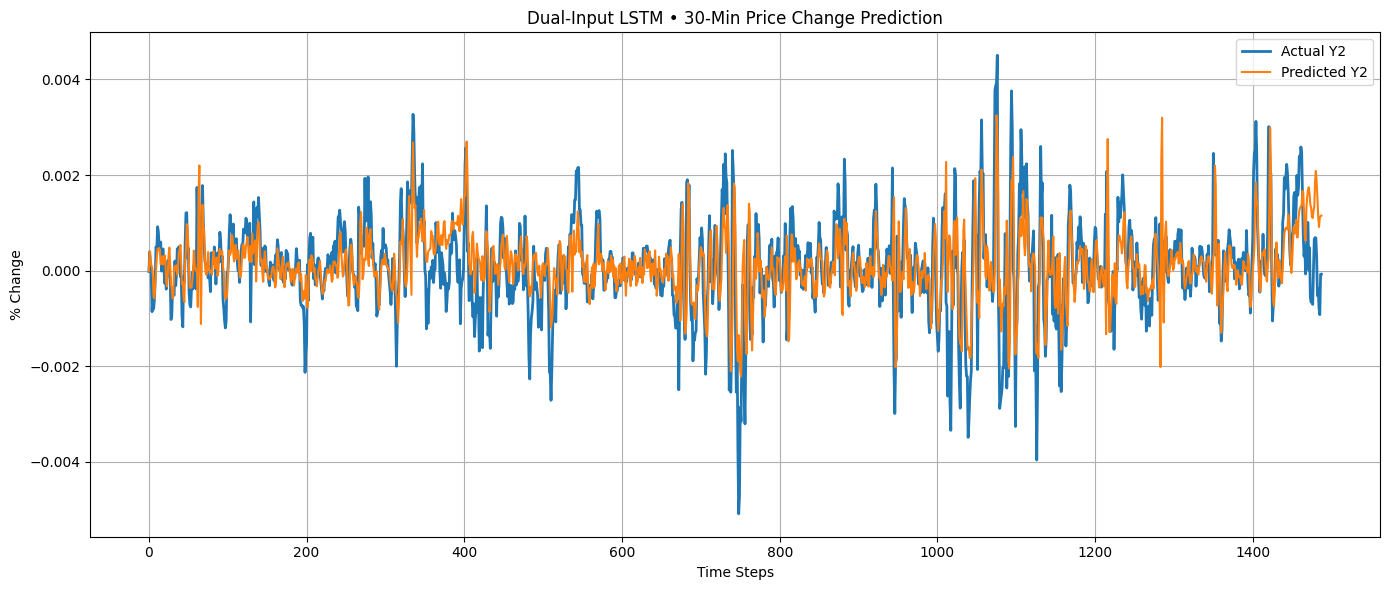

In [43]:
# --- STEP 8: Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label="Actual Y2", linewidth=2)
plt.plot(y_pred_inv, label="Predicted Y2")
plt.title("Dual-Input LSTM • 30-Min Price Change Prediction")
plt.xlabel("Time Steps")
plt.ylabel("% Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# ── compute dynamic Bull/Bear cutoffs from the train‑set pct changes ──
import numpy as np

pct_train = scaler_y.inverse_transform(y_train_seq).flatten() * 100
# ── AFTER you build pct_train (in % units) ──
mu, sigma = pct_train.mean(), pct_train.std()
k = 1.0   # you can try 0.5, 1.0, 1.5…
up_th   = mu + k*sigma
down_th = mu - k*sigma

print(f"Std‑based thresholds ⇒ Bullish > {up_th:.3f}%   Bearish < {down_th:.3f}%")





Std‑based thresholds ⇒ Bullish > 0.102%   Bearish < -0.105%


In [48]:
# ───────────────  ON‑DEMAND 30‑MIN‑AHEAD PREDICTION  ────────────────
import numpy as np, pandas as pd

# 1) your dynamic thresholds from training
#    (you should have printed these just after training)
#    e.g. up_th  = np.percentile(pct_train, 75)
#         down_th= np.percentile(pct_train, 25)

def pct_to_trend(pct, up_thr=up_th, down_thr=down_th):
    if pct >  up_thr:    return "Bullish"
    if pct <  down_thr:  return "Bearish"
    return "Consolidation"

# 2) rebuild exactly the columns you engineered during training
def make_one_row(user_dict):
    row = pd.Series(user_dict).copy()
    # diffs
    row["A2_A1_diff"] = row["A2"] - row["A1"]
    row["B2_B1_diff"] = row["B2"] - row["B1"]
    row["C2_C1_diff"] = row["C2"] - row["C1"]
    # expiry pressure
    days = (pd.to_datetime(row["Expiry_date"]).normalize()
          - pd.to_datetime(row["Date"]).normalize()).days
    row["expiry_pressure"] = 1 / (1 + max(days,0))
    # placeholders
    for c in ["ret_1","ret_5","volatility","price_norm","Y2_lag1","client_score"]:
        row[c] = 0.0
    return row

# 3) declare exactly the same feature‑lists you used at train time
raw_features = ["A1","A2","B1","B2","C1","C2"]
eng_features = [
    "A2_A1_diff","B2_B1_diff","C2_C1_diff",
    "ret_1","ret_5","volatility",
    "price_norm","Y2_lag1","expiry_pressure","client_score"
]

def predict_30min_ahead(user_dict):
    # rebuild row
    row = make_one_row(user_dict)

    # RAW branch
    raw_vec = row[raw_features].values.reshape(1,-1)
    seq_raw = np.repeat(
        scaler_X_raw.transform(raw_vec)[np.newaxis,:,:],
        time_steps, axis=1
    )

    # ENG branch (ONLY eng_features!)
    eng_vec = row[eng_features].values.reshape(1,-1)
    seq_eng = np.repeat(
        scaler_X_eng.transform(eng_vec)[np.newaxis,:,:],
        time_steps, axis=1
    )

    # forward pass
    pct_scaled = model.predict([seq_raw, seq_eng])[0,0]
    pct_change = scaler_y.inverse_transform([[pct_scaled]])[0,0] * 100

    # map to direction
    trend = pct_to_trend(pct_change)
    return trend, round(pct_change,3)

# ─── Test it!
if __name__=="__main__":
    demo = {
    "Expiry_date": "2025-01-30",
    "Date"       : "2025-01-21",
    "Time"       : "11:20:00",
    "PRICE"      : 48772,
    "A1"         : 1148093863,
    "B1"         : 8018657988,
    "C1"         : 1531825535,
    "A2"         : 189375395,
    "B2"         : 31420822010,
    "C2"         : 38740463612
}

    t,p = predict_30min_ahead(demo)
    print(f"🔮 Trend: {t}   |   Expected 30‑min move: {p:+.3f}%")


1/1 [==============================] - 0s 31ms/step
🔮 Trend: Consolidation   |   Expected 30‑min move: -0.100%


C:\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [46]:
# ─────────────────────────────────────────────────────────────────────────────────
#  📍 FINAL CELL: On‑demand 30‑min Predictor (no duplicate-index slicing)
# ─────────────────────────────────────────────────────────────────────────────────

import numpy as np, pandas as pd

# 1) Re‑compute your std‑based thresholds (you already had these)
pct_train = scaler_y.inverse_transform(y_train_seq).flatten() * 100
mu, sigma = pct_train.mean(), pct_train.std()
k = 1.0
up_th   = mu + k*sigma
down_th = mu - k*sigma
print(f"🔧 Thresholds ⇒ Bullish > {up_th:.3f}%   Bearish < {down_th:.3f}%")

def pct_to_trend(pct):
    if pct >  up_th:    return "Bullish"
    if pct <  down_th:  return "Bearish"
    return "Consolidation"

# 2) Same per‑row engineering you used in training
def make_one_row(user_dict):
    r = pd.Series(user_dict).copy()
    r["A2_A1_diff"] = r["A2"] - r["A1"]
    r["B2_B1_diff"] = r["B2"] - r["B1"]
    r["C2_C1_diff"] = r["C2"] - r["C1"]
    days = (pd.to_datetime(r["Expiry_date"]).normalize()
          - pd.to_datetime(r["Date"]).normalize()).days
    r["expiry_pressure"] = 1.0/(1+max(days,0))
    for c in ["ret_1","ret_5","volatility","price_norm","Y2_lag1","client_score"]:
        r[c] = 0.0
    return r

# 3) On‑demand predictor using the last `time_steps` real bars
def predict_30min_ahead(user_dict, df_feat, time_steps=6):
    # build & timestamp new row
    row = make_one_row(user_dict)
    ts  = pd.to_datetime(f"{user_dict['Date']} {user_dict['Time']}")
    row.name = ts

    # ensure sorted history
    hist = df_feat.sort_index()

    # 3a) take the last (time_steps-1) rows before ts
    prev = hist[hist.index < ts].iloc[-(time_steps-1):]
    if len(prev) < time_steps-1:
        raise ValueError(f"Need {time_steps-1} history rows, got {len(prev)}")

    # 3b) append the new row
    seq = pd.concat([prev, row.to_frame().T])

    # 3c) split branches & scale
    Xr = scaler_X_raw.transform(seq[raw_features]).reshape(1, time_steps, len(raw_features))
    Xe = scaler_X_eng.transform(seq[eng_features]).reshape(1, time_steps, len(eng_features))

    # 3d) LSTM forward & inverse‐scale
    pct_s = model.predict([Xr, Xe])[0,0]
    pct   = scaler_y.inverse_transform([[pct_s]])[0,0] * 100
    return pct_to_trend(pct), round(pct,3)

# ─────────────────────────────────────────────────────────────────────────────────
# 4) Demo test
demo = {
    "Expiry_date": "2025-01-30",
    "Date"       : "2025-01-21",
    "Time"       : "11:20:00",
    "PRICE"      : 48772,
    "A1"         : 1148093863,
    "B1"         : 8018657988,
    "C1"         : 1531825535,
    "A2"         : 189375395,
    "B2"         : 31420822010,
    "C2"         : 38740463612
}

trend, pct = predict_30min_ahead(demo, df_feat, time_steps=6)
print(f"🔮 Trend: {trend}   |   Expected 30‑min move: {pct:+.3f}%")


🔧 Thresholds ⇒ Bullish > 0.102%   Bearish < -0.105%
1/1 [==============================] - 0s 22ms/step
🔮 Trend: Consolidation   |   Expected 30‑min move: -0.005%


In [50]:
import pickle

# 1) trained dual‑LSTM
with open("dual_lstm_model.pkl", "wb") as f:
    pickle.dump(model, f)

# 2) scalers
with open("scaler_X_raw.pkl", "wb") as f:
    pickle.dump(scaler_X_raw, f)
with open("scaler_X_eng.pkl", "wb") as f:
    pickle.dump(scaler_X_eng, f)
with open("scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

# 3) your feature‑history DataFrame (needed for on‑the‑fly sequences)
df_feat = df[ raw_features + eng_features ].copy()
with open("df_feature_history.pkl", "wb") as f:
    pickle.dump(df_feat, f)

# 4) pre‑compute your thresholds one time
import numpy as np
pct_train = scaler_y.inverse_transform(y_train_seq).flatten() * 100
up_th   = np.percentile(pct_train, 90)
down_th = np.percentile(pct_train, 10)
with open("trend_thresholds.pkl", "wb") as f:
    pickle.dump((up_th, down_th), f)

print("✅ All artifacts saved to disk.")


✅ All artifacts saved to disk.
